In [1]:
# libabries for data exploration.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helpful_functions import MLFunctions

# time series specific libararies
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.offsetbox import AnchoredText
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    usecols=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'],
                    index_col=['date'], 
                    parse_dates=['date'],
                    date_format="%d.%m.%Y")

In [3]:
sales = sales.sort_index()
helper_function = MLFunctions(sales)
arr = helper_function.dateNum()
sales['time'] = arr

In [4]:
date_shop_sum = sales.groupby(['date','shop_id']).sum()[['item_cnt_day']]
date_shop_count = sales.groupby(['date','shop_id']).nunique()[['item_id']]
date_shop_mean = sales.groupby(['date','shop_id']).mean()[['item_price']]
date_shop_median = sales.groupby(['date','shop_id']).median()[['time']]
sales_agg = pd.concat([date_shop_sum, date_shop_count, date_shop_mean, date_shop_median], axis=1)

In [5]:
sales_agg = sales_agg.reset_index()
sales_agg.index = sales_agg['date']

<Axes: xlabel='time'>

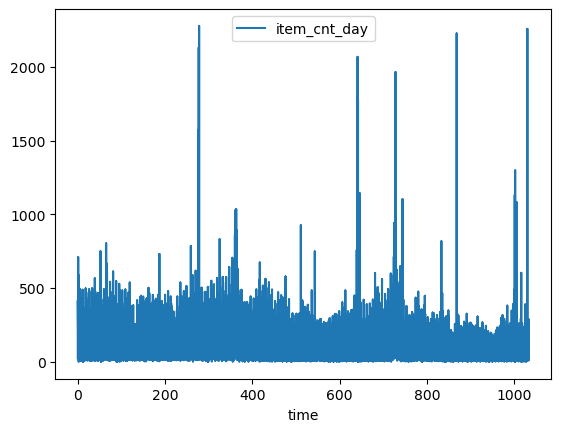

In [6]:
sales_agg.plot(kind='line', x='time', y='item_cnt_day')

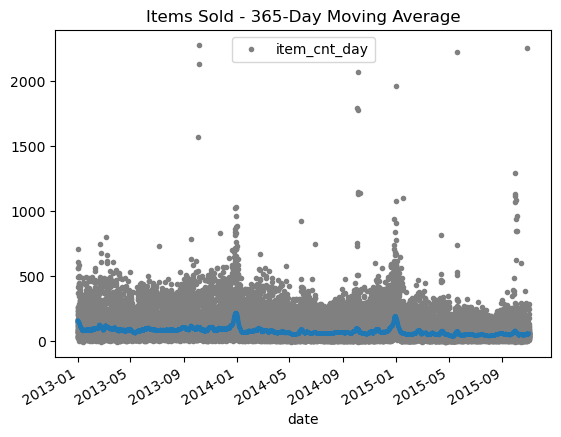

In [7]:
moving_average = sales_agg[['item_cnt_day']].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = sales_agg[['item_cnt_day']].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Items Sold - 365-Day Moving Average", legend=False,
);

<Axes: xlabel='time'>

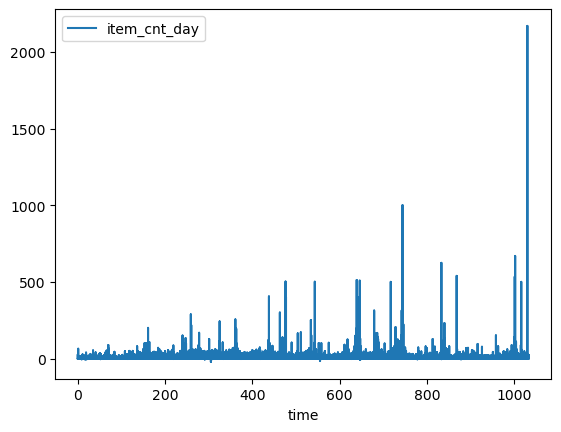

In [8]:
sales.plot(kind='line', x='time', y='item_cnt_day')

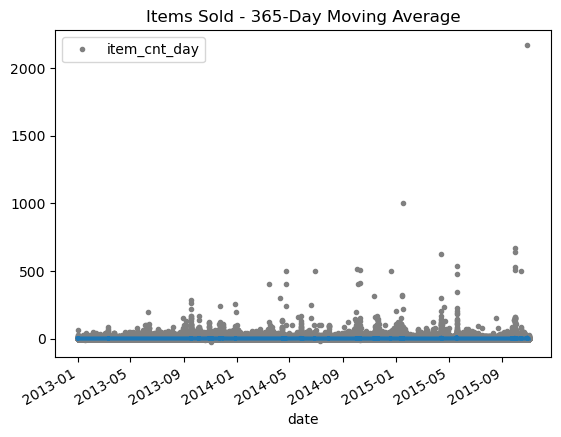

In [9]:
moving_average = sales[['item_cnt_day']].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = sales[['item_cnt_day']].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Items Sold - 365-Day Moving Average", legend=False,
);

<Axes: xlabel='time'>

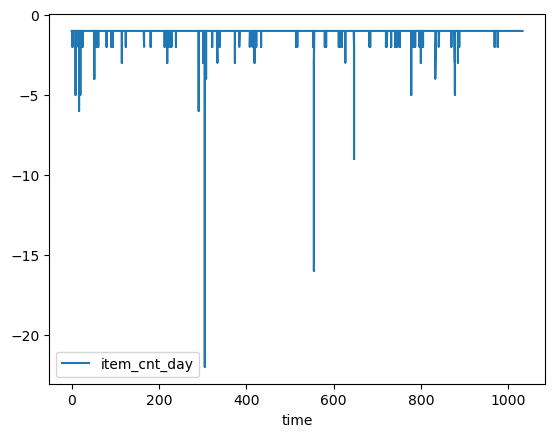

In [10]:
sales.loc[sales['item_cnt_day']<0, :].plot(x='time', y='item_cnt_day')

In [11]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

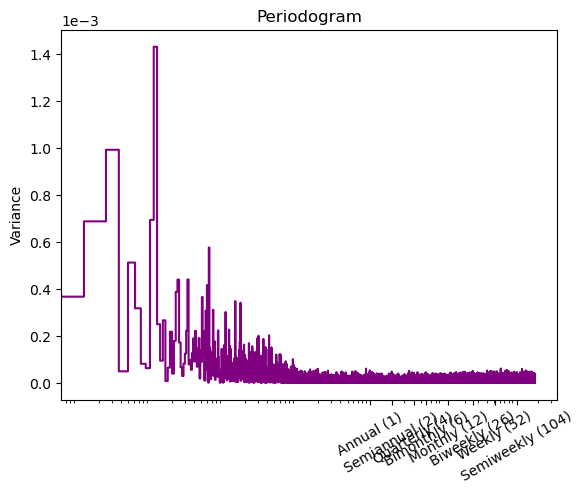

In [12]:
plot_periodogram(sales.item_cnt_day)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

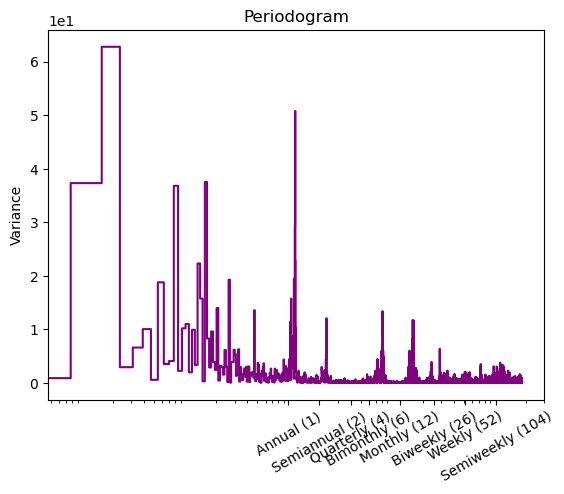

In [26]:
plot_periodogram(sales_agg.item_cnt_day)

In [34]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [147]:
fs = 10e3
N = 1e5
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += rng.normal(scale=np.sqrt(noise_power), size=time.shape)

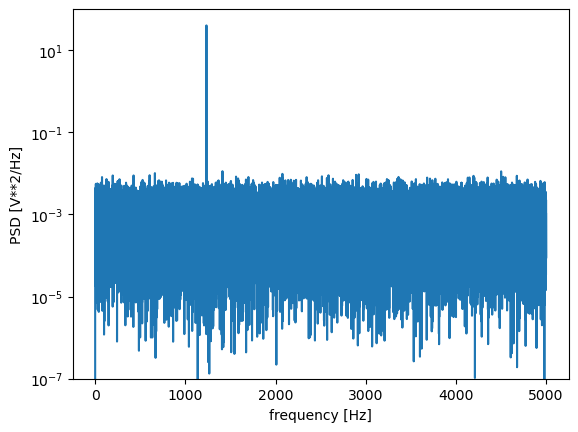

In [50]:
f, Pxx_den = signal.periodogram(x, fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show() 

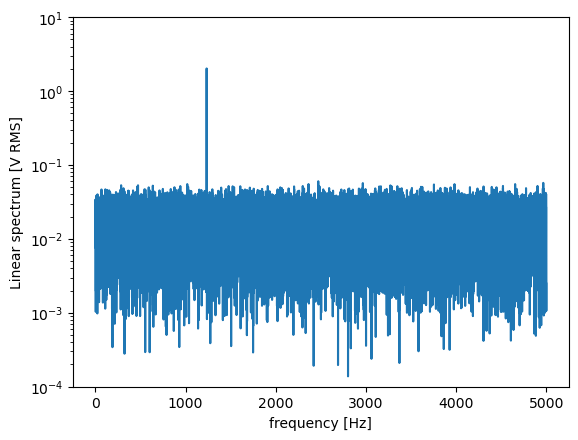

In [51]:
f, Pxx_spec = signal.periodogram(x, fs, 'flattop', scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.ylim([1e-4, 1e1])
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()